In [1]:
import numpy as np
from numpy import concatenate
import pandas as pd
import tensorflow as tf
import keras
import math
import seaborn as sns
from scipy.optimize import curve_fit
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers import Flatten
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
solar_data = pd.read_csv('./data/train/train.csv',encoding='utf-8')

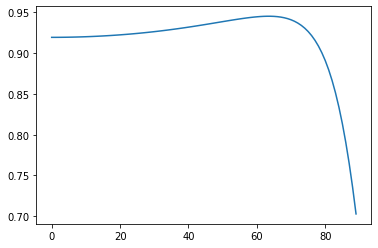

63 0.9451229383187152


In [3]:
corrList = []
corr = lambda p : p['TARGET'].corr(p['GHI'])

def makeCorrList(df):
    result = corr(df)
    corrList.append(result)

for i in range(0,90):
    solar_data['GHI'] = solar_data['DNI']*math.cos(math.pi/180*i)+solar_data['DHI']
    makeCorrList(solar_data)

x = np.arange(0,90)
plt.plot(x,corrList)
plt.show()

print(corrList.index(max(corrList)), max(corrList))

In [4]:
solar_data['GHI'] = solar_data['DNI']*math.cos(math.pi/180*63)+solar_data['DHI']

In [5]:
def eval_dewpoint(T, RH):
    b = 17.62
    c = 243.12
    gamma = (b * T / (c + T)) + math.log(RH / 100.0)
    dewpoint = (c * gamma) / (b - gamma)
    return dewpoint

In [6]:
for i in range(len(solar_data)):
    solar_data.loc[i, ["DP"]] = eval_dewpoint(float(solar_data.loc[i, ["T"]]), solar_data.loc[i , ["RH"]])

In [7]:
solar_data = solar_data.reindex(columns=["Day", "Hour", "Minute", "GHI", "DHI", "DNI", "WS", "RH", "T", "DP", "TARGET"])

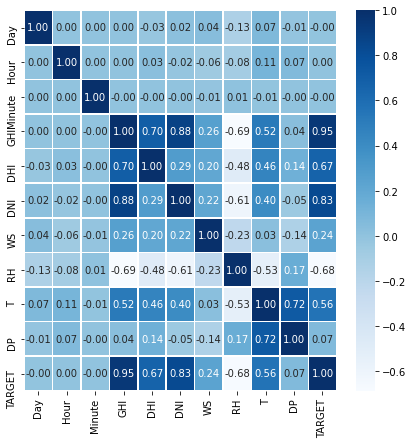

In [8]:
mask = (solar_data.Hour==12)&(solar_data.Minute==00)
# solar_data_filtered = solar_data.loc[mask,:]
# solar_data_filtered.drop(['Day', 'Hour','Minute'], axis='columns', inplace=True)
plt.figure(figsize=(7, 7))
# sns.heatmap(data=solar_data_filtered.corr(), annot=True,fmt='.2f', linewidths=.5, cmap='Blues')
sns.heatmap(data=solar_data.corr(), annot=True,fmt='.2f', linewidths=.5, cmap='Blues')
plt.rcParams['font.family'] = 'NanumGothic'

In [9]:
solar_data.drop(['Day', 'Hour','Minute'], axis='columns', inplace=True)

In [10]:
class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

def create_dataset(solar_data, index):
    dataX, dataY = [], []
    for i in range(0,48*7):
        dataX.append(list(np.array(solar_data.loc[index+i].tolist())))
    for i in range(48*7,48*7+48*2):
        dataY.append(solar_data.loc[index+i,'TARGET'])
    return np.array(dataX), np.array(dataY)

In [11]:
# 데이터셋 생성
input_data, output_data = [], []

last_index = 3*365*48-48*9
list_index = list(range(0,last_index,48))

# last_index = 3*365*48 - 432
# list_index = list(0:last_index,1))

for i in list_index:
    X, Y = create_dataset(solar_data,i)
    input_data.append(X)
    output_data.append(Y)

In [12]:
input_array = np.array(input_data)
output_array = np.reshape(np.array(output_data),(1086,96,1))

In [14]:
# 데이터셋 분배
train_x, test_x, train_y, test_y = train_test_split(input_array, output_array, test_size = 0.1,shuffle = False)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.1,shuffle=False)

# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
# train_x = train_x.reshape((train_x.shape[0], 7, 1, 48, 6))

In [15]:
# model = Sequential()
# for i in range(2):
#     model.add(LSTM(32, batch_input_shape=(1, 336, 8), stateful=True, return_sequences=True))
#     model.add(Dropout(0.3))
# model.add(LSTM(32, batch_input_shape=(1, 336, 8), stateful=True))
# model.add(Dropout(0.3))
# model.add(Dense(96))
# model.compile(loss='mean_squared_error', optimizer='adam')
# custom_hist = CustomHistory()
# custom_hist.init()
# for i in range(100):
#     # model.fit(train_x, train_y, epochs=1, batch_size=1, shuffle=False, callbacks=[custom_hist], validation_data=(val_x, val_y))
#     model.fit(train_x, train_y, epochs=1, batch_size=1, shuffle=False, validation_data=(val_x, val_y))
#     model.reset_states()

[[ 0.          0.          0.         ... 15.         10.89391998
   0.        ]
 [ 0.          0.          0.         ... 15.         10.88800989
   0.        ]
 [ 0.          0.          0.         ... 15.         10.20252115
   0.        ]
 ...
 [ 0.          0.          0.         ... 10.          4.95894267
   0.        ]
 [ 0.          0.          0.         ... 10.          4.81034396
   0.        ]
 [ 0.          0.          0.         ...  9.          4.82526313
   0.        ]]
(336, 8)
[[ 6.39446080e-06  2.03350559e-04  2.53042206e-04  7.55302608e-06
   8.54656100e-05  2.39815563e-05  7.14566559e-05  1.19024888e-04
   4.04283695e-04  4.09446657e-04  1.83681965e+00  4.16808748e+00
   5.73782921e+00  7.08571434e+00  9.24719524e+00  9.29168987e+00
   1.10422926e+01  1.06920471e+01  1.13013725e+01  1.16078339e+01
   1.22838917e+01  1.23574286e+01  1.17632704e+01  1.20319967e+01
   1.16902695e+01  1.27284145e+01  1.17336016e+01  1.26387749e+01
   1.12293205e+01  1.19616489e+01  1.

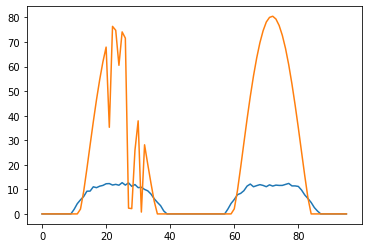

In [27]:
# 모델 사용하기
xhat = test_x[5]
print(xhat)
print(xhat.shape)
prediction = model.predict(np.array([xhat]), batch_size=1)
print(prediction)
print(prediction.shape)
print(max(prediction[0]))

plt.plot(np.reshape(prediction,(96)))
plt.plot(test_y[5])

In [26]:
import keras.backend as K

submission = pd.read_csv('./data/sample_submission.csv')
submission.set_index('id',inplace=False)
test = []
for i in range(81):
    data = []
    tmp = pd.read_csv(f'./data/test/{i}.csv')
    tmp.drop(['Day', 'Hour','Minute'], axis='columns', inplace=True)
    for i in range(0,48*7):
        data.append(list(np.array(solar_data.loc[i].tolist())))
    test.append(data)
test = np.array(test)

def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

for i, q in enumerate(np.arange(0.1, 1, 0.1)):
  print(q)
  model = Sequential()
  # for l in range(2):
  #     model.add(LSTM(32, batch_input_shape=(1, 336, 8), stateful=True, return_sequences=True))
  #     model.add(Dropout(0.3))
  model.add(LSTM(32, batch_input_shape=(1, 336, 8), stateful=True))
  # model.add(Dropout(0.3))
  model.add(Dense(96))
  model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer='adagrad')
  # for j in range(10):
  #   # model.fit(train_x, train_y, epochs=1, batch_size=1, shuffle=False, callbacks=[custom_hist], validation_data=(val_x, val_y))
  #   model.fit(train_x, train_y, epochs=1, batch_size=1, shuffle=False, validation_data=(val_x, val_y))
  #   model.reset_states()
  model.fit(train_x, train_y, epochs=100, batch_size=1, shuffle=False, validation_data=(val_x, val_y))
  predictions = []
  for k in range(81):
    prediction = model.predict(np.array([test[k]]), batch_size=1)
    predictions.append(prediction)
  predictions = np.reshape(np.concatenate(np.array(predictions), axis=0),(81*96))
  submission.iloc[:,i+1] = predictions
  print(predictions)
submission.to_csv(f'submission.csv', index=False)
print('finish')

0.1
Epoch 1/100
879/879 [==============================] - 12s 12ms/step - loss: 1.7880 - val_loss: 2.3568
Epoch 2/100
879/879 [==============================] - 10s 11ms/step - loss: 1.7446 - val_loss: 2.3422
Epoch 3/100
879/879 [==============================] - 10s 11ms/step - loss: 1.7309 - val_loss: 2.3342
Epoch 4/100
879/879 [==============================] - 10s 11ms/step - loss: 1.7237 - val_loss: 2.3297
Epoch 5/100
879/879 [==============================] - 10s 11ms/step - loss: 1.7195 - val_loss: 2.3272
Epoch 6/100
879/879 [==============================] - 10s 11ms/step - loss: 1.7170 - val_loss: 2.3253
Epoch 7/100
879/879 [==============================] - 10s 12ms/step - loss: 1.7152 - val_loss: 2.3236
Epoch 8/100
879/879 [==============================] - 10s 11ms/step - loss: 1.7135 - val_loss: 2.3220
Epoch 9/100
879/879 [==============================] - 10s 11ms/step - loss: 1.7119 - val_loss: 2.3204
Epoch 10/100
879/879 [==============================] - 10s 11ms/step

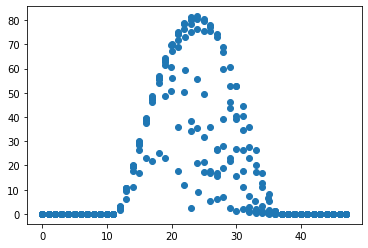

In [ ]:
data = test_x[4][:,5]
x,y = [],[]
for i in range(336):
  x.append(i%48)
  y.append(data[i])
x = x + 0.01*np.random.normal(size=len(x))
plt.plot(x,y,'o')
plt.show()

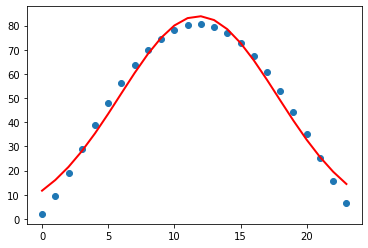

In [ ]:
def func(x, amp, cen, wid):
    return (amp / (sqrt(2*pi) * wid)) * exp(-(x-cen)**2 / (2*wid**2))

x = np.arange(48)
# y = np.reshape(prediction,(96))[0:48]
y = np.reshape(test_y[6],(96))[00:48]
mod_y = np.delete(y, np.where(y==0))
# mod_y = y 
x = np.arange(len(mod_y))
plt.plot(mod_y,'o')
popt, _ = optimize.curve_fit(func, x, mod_y)
plt.plot(func(x, *popt), linewidth=2, color='red')
plt.show()

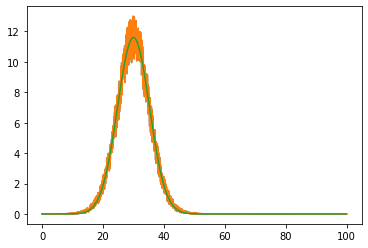

In [ ]:
import numpy as np
from astropy import modeling

m = modeling.models.Gaussian1D(amplitude=10, mean=30, stddev=5)
x = np.linspace(0, 100, 2000)
data = m(x)
data = data + np.sqrt(data) * np.random.random(x.size) - 0.5
data -= data.min()
plt.plot(x, data)

from scipy import optimize

def gaussian(x, amplitude, mean, stddev):
       return amplitude * np.exp(-((x - mean) / 4 / stddev)**2)

popt, _ = optimize.curve_fit(gaussian, x, data)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 92
    # data points      = 48
    # variables        = 3
    chi-square         = 639.997152
    reduced chi-square = 14.2221589
    Akaike info crit   = 130.332610
    Bayesian info crit = 135.946213
[[Variables]]
    amp:  1226.69644 +/- 20.8767808 (1.70%) (init = 1)
    cen:  23.8024459 +/- 0.11325527 (0.48%) (init = 24)
    wid:  5.76315942 +/- 0.11325540 (1.97%) (init = 12)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) =  0.577


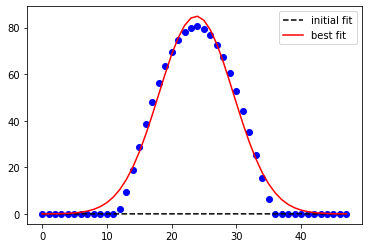

In [ ]:
import matplotlib.pyplot as plt
from numpy import exp, loadtxt, pi, sqrt

from lmfit import Model
x = np.arange(48)
# y = np.reshape(prediction,(96))[0:48]
y = np.reshape(test_y[6],(96))[00:48]
# mod_y = np.delete(y, np.where(y==0))
mod_y = y 
x = np.arange(len(mod_y))


def gaussian(x, amp, cen, wid):
    return (amp / (sqrt(2*pi) * wid)) * exp(-(x-cen)**2 / (2*wid**2))
gmodel = Model(gaussian)
result = gmodel.fit(mod_y, x=x, amp=1, cen=24, wid=12)

print(result.fit_report())

plt.plot(x, mod_y, 'bo')
plt.plot(x, result.init_fit, 'k--', label='initial fit')
plt.plot(x, result.best_fit, 'r-', label='best fit')
plt.legend(loc='best')
plt.show()